## SVO Extraction Guide

This notebook is a guide to visualizing the frequency of the subjects, verbs and objects present in articles. To ensure accuracy, please check the quality of the data before proceeding — ideally, the text should be pre-processed. A code cell containing the pre-processing algorithm is included in the NGramsGuide.ipynb notebook, so run it if needed.

## Setup

Import the necessary packages. It may be necessary to ![install](https://packaging.python.org/en/latest/tutorials/installing-packages/) the packages if they are not already in your Python kernel.

In [46]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import sklearn.cluster
import re
import spacy
from matplotlib import pyplot as plt

Load the data set(s). Change the argument to include the path on your local computer that leads to the file. For example, if the file is in your Downloads folder, the path may look like /Users/firstnamelastname/Downloads/Bridging Racial Violence Compiled Data.xlsx.

In [47]:
nyt = pd.read_excel('/Users/clairefenton/Desktop/Emory/BRV Research/Data/NYT_Predictions.xlsx')
atl70 = pd.read_excel('/Users/clairefenton/Desktop/Emory/BRV Research/Data/ATL_1970_Predictions_new_preprocessing.xlsx')
atl70 = atl70[atl70.columns[2:]]

## SVO Extraction

Using spaCy, we can examine the grammatical taggings within a sentence and extract which entities are the subjects, objects and verbs. The `extract_svo` function creates three separate lists containing the subjects, objects and verbs and takes four arguments:
* doc: string value representing the cleaned text of an article
* sub: an empty list to contain string values representing the subjects
* at: an empty list to contain string values representing the objects
* ve: an empty list to contain string values representing the verbs

In [48]:
nlp = spacy.load("en_core_web_sm")

OBJECT_DEPS = {"dobj", "dative", "attr", "oprd"}
SUBJECT_DEPS = {"nsubj", "nsubjpass", "csubj", "agent", "expl"}

def extract_svo(doc, sub, at, ve):
    for token in doc:
        if token.pos_ == "VERB":
            ve.append(token.text)
        if token.dep_ in OBJECT_DEPS or token.head.dep_ in OBJECT_DEPS:
            at.append(token.text)
        if token.dep_ in SUBJECT_DEPS or token.head.dep_ in SUBJECT_DEPS:
            sub.append(token.text)

Loop through all the articles in the chosen data set and perform SVO extraction to examine the frequency of each across a publication for a given year.

In [49]:
sub = []
at = []
ve = []
for i in range(len(atl70)):
    doc = nlp(atl70['text'].iloc[i])
    extract_svo(doc, sub, at, ve)

We can take a look at the top 20 most frequently occurring subjects in the Atlanta Daily World in 1970.

In [50]:
pd.Series(sub).value_counts()[:20]

police           900
man              699
men              415
two              392
shoot            387
state            346
black            311
atlanta          279
one              276
officer          260
report           248
victim           242
investigators    231
students         215
charge           215
detectives       206
city             190
people           186
arrest           163
court            162
Name: count, dtype: int64

What about for articles containing racial violence?

In [51]:
sub = []
at = []
ve = []
for i in range(len(atl70[atl70['CF_Correct'] == 1])):
    doc = nlp(atl70[atl70['CF_Correct'] == 1].reset_index()['text'].iloc[i])
    extract_svo(doc, sub, at, ve)

pd.Series(sub).value_counts()[:20]

police       198
black        152
state        109
students     100
two           93
officer       91
negro         78
one           77
city          69
jackson       68
white         67
officials     65
school        62
people        61
charge        60
men           58
court         58
policemen     56
man           54
negroes       54
Name: count, dtype: int64

## Visualizing Frequency Counts

The number of words to show is at your discretion, but around 20 is recommended. The color and width of the bars (lightblue, 0.4) can be adjusted using the in the `plt.bar` function. The labels for the axes can be edited in the `plt.xlabel` and `plt.ylabel` functions, and the title in the `plt.title` function.

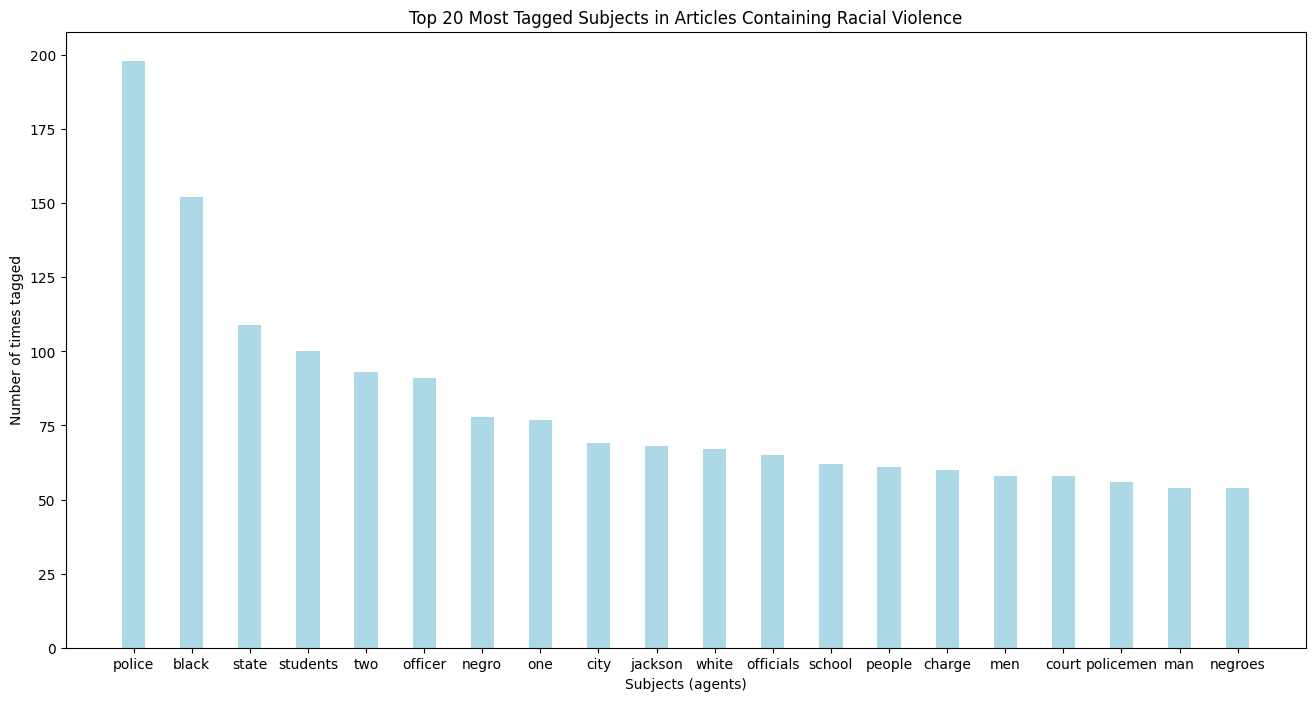

In [52]:
top_20_subjects = pd.Series(sub).value_counts().head(20)
values = top_20_subjects.values
words = top_20_subjects.index

fig = plt.figure(figsize = (16, 8))

plt.bar(words, values, color ='lightblue',
		width = 0.4)

plt.xlabel("Subjects (agents)")
plt.ylabel("Number of times tagged")
plt.title("Top 20 Most Tagged Subjects in Articles Containing Racial Violence")
plt.show()

Sometimes, it may be preferable for the scale of the axis to be in percentages to make for more reliable comparisons across different publications and years.

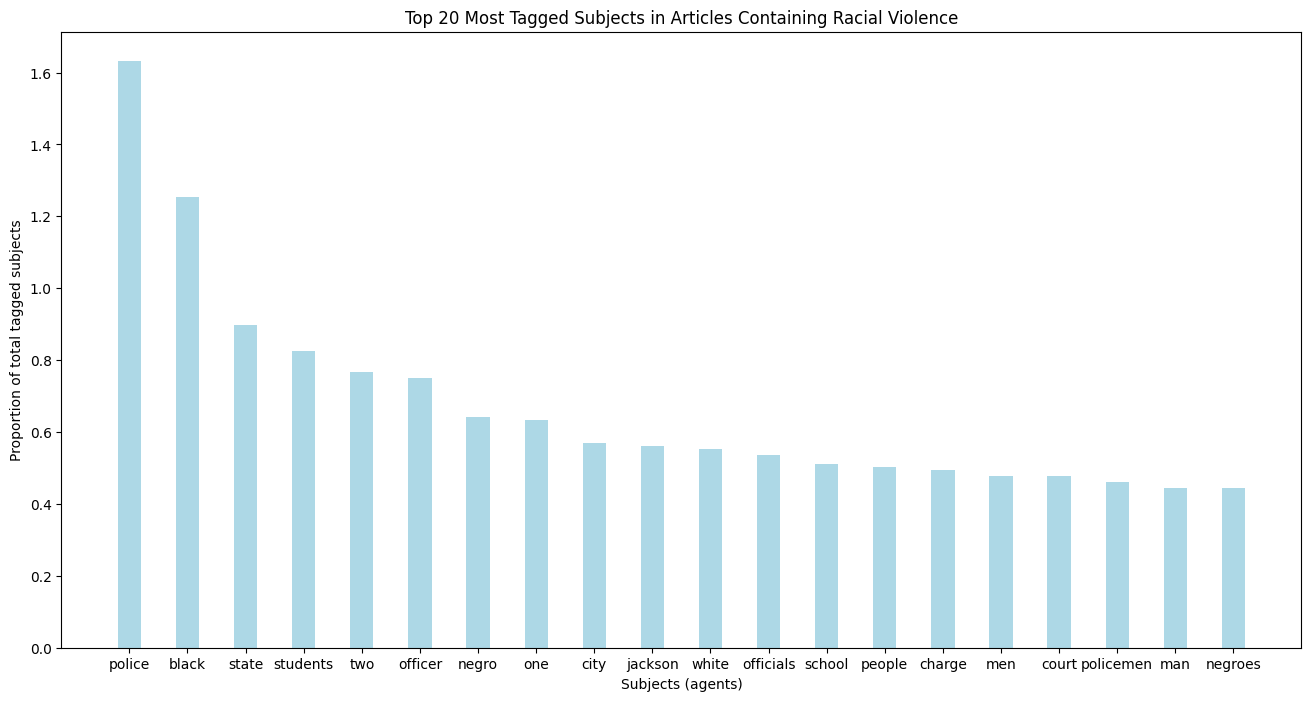

In [53]:
top_20_subjects_prop = (pd.Series(sub).value_counts().head(20)/sum(pd.Series(sub).value_counts().values)) * 100
values = top_20_subjects_prop.values
words = top_20_subjects_prop.index

fig = plt.figure(figsize = (16, 8))

plt.bar(words, values, color ='lightblue',
		width = 0.4)

plt.xlabel("Subjects (agents)")
plt.ylabel("Proportion of total tagged subjects")
plt.title("Top 20 Most Tagged Subjects in Articles Containing Racial Violence")
plt.show()

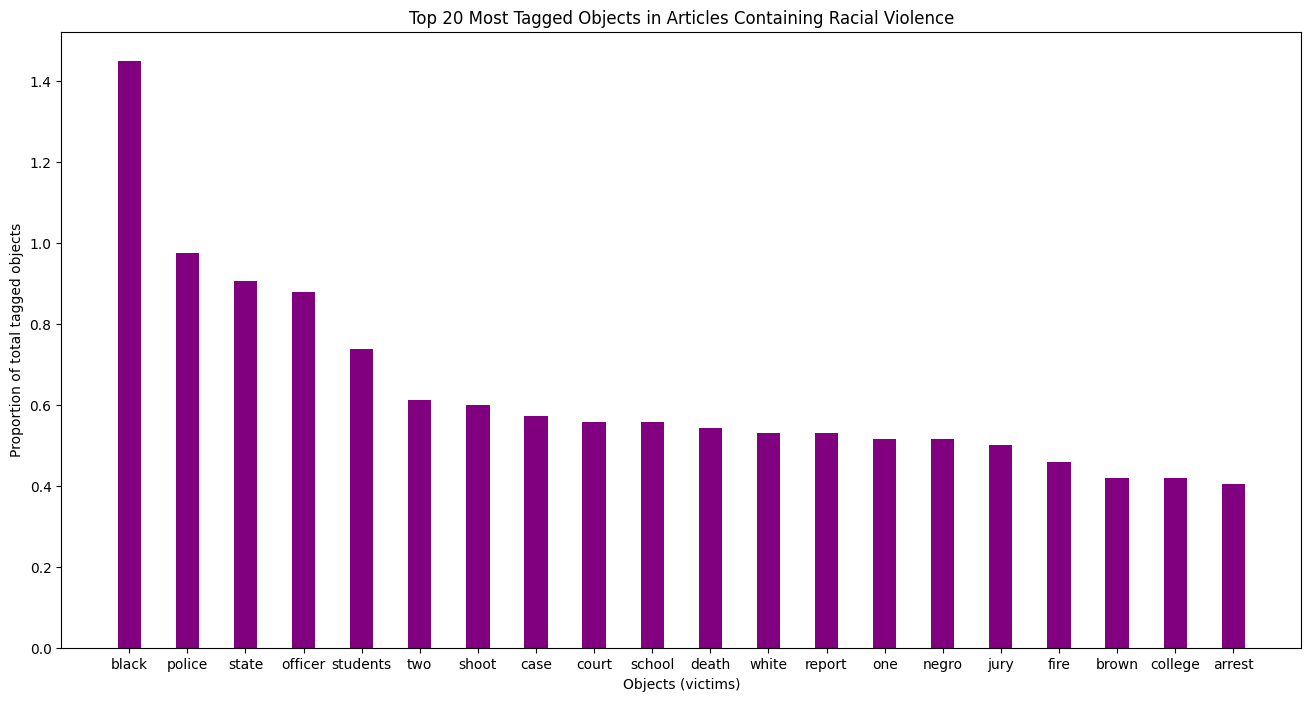

In [54]:
top_20_objects_prop = (pd.Series(at).value_counts().head(20)/sum(pd.Series(at).value_counts().values)) * 100
values = top_20_objects_prop.values
words = top_20_objects_prop.index

fig = plt.figure(figsize = (16, 8))

plt.bar(words, values, color ='purple',
		width = 0.4)

plt.xlabel("Objects (victims)")
plt.ylabel("Proportion of total tagged objects")
plt.title("Top 20 Most Tagged Objects in Articles Containing Racial Violence")
plt.show()

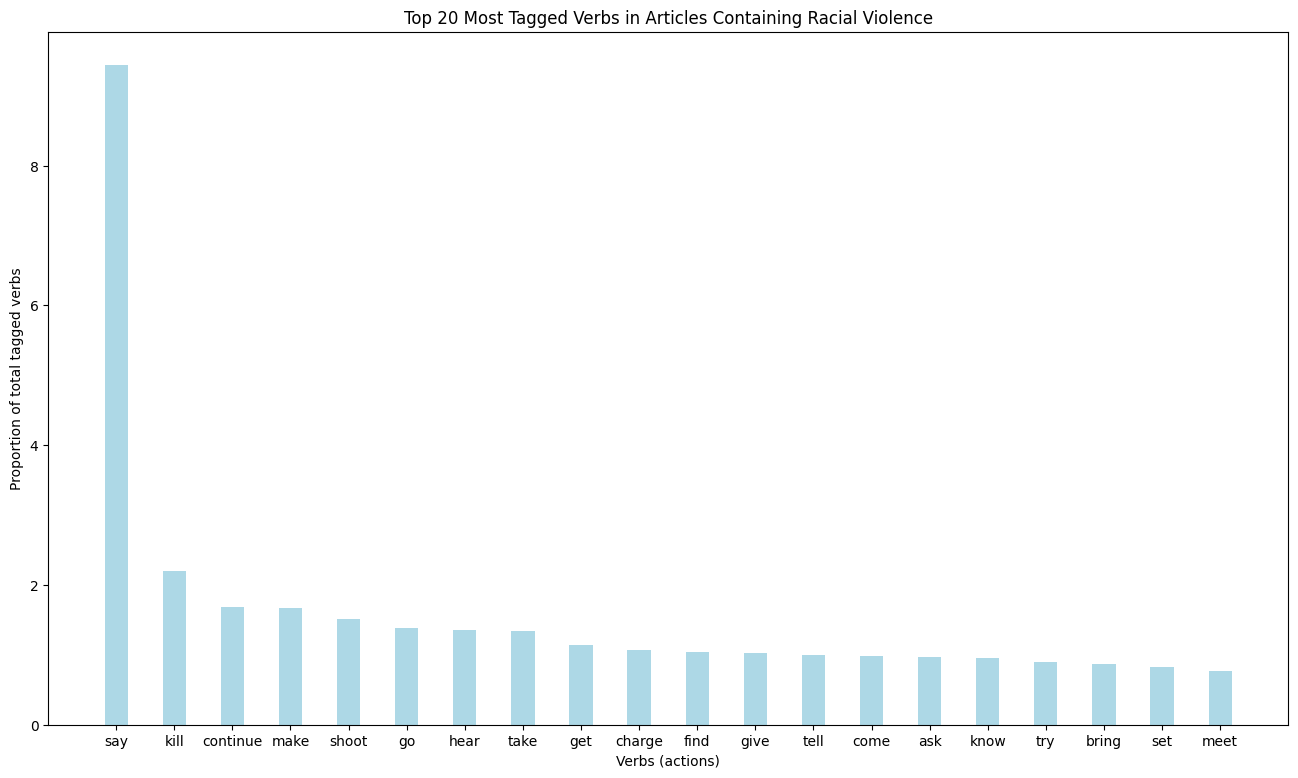

In [55]:
top_20_verbs_prop = (pd.Series(ve).value_counts().head(20)/sum(pd.Series(ve).value_counts().values)) * 100
values = top_20_verbs_prop.values
words = top_20_verbs_prop.index

fig = plt.figure(figsize = (16, 9))

plt.bar(words, values, color ='lightblue',
		width = 0.4)

plt.xlabel("Verbs (actions)")
plt.ylabel("Proportion of total tagged verbs")
plt.title("Top 20 Most Tagged Verbs in Articles Containing Racial Violence")
plt.show()

It might be easier to create a function that makes all three charts and performs the various extractions all at once. Additionally, removing some of the more commonly uninformative words from the verbs chart (i.e. "say," "make," "go") can help better illuminate more substantive actions.

The function `clean_verbs` takes a list of words and their counts and removes all words in the list `verbs_to_remove`, which can be adjusted as you see fit.

In [56]:
def clean_verbs(data):
    values = data.values
    words = data.index
    verb_counts = {}
    for i in range(len(words)):
        verb_counts[words[i]] = values[i]
    verbs_to_remove = ['say', 'make', 'take', 'go', 'tell', 'find', 'give', 'continue', 'come', 'get', 'ask', 'know', 'enter', 'hear', 'appear', 'set', 'put']
    for verb in verbs_to_remove:
        if verb in list(verb_counts.keys()):
            del verb_counts[verb]
    return pd.Series(data=verb_counts, index=list(verb_counts.keys()))

The function `create_hist` creates three histograms containing word frequencies and takes the following arguments:
* sov: an NLP doc created from spaCy
* publication: a string value representing the name(s) of the pubication(s) from which the articles come from
* cutoff: integer value representing the number of words to appear in the charts

The function `hist_top_sov` creates three histograms containing word frequencies and takes the following arguments:
* df: a data frame containing the data to be visualized
* text_col: a string value representing the column in df containing the preprocessed text
* publication: a string value representing the name(s) of the pubication(s) from which the articles come from

In [57]:
aes_dict = {
    'sub' : {
        'index' : 0,
        'color' : 'green',
        'name' : 'Subjects'
    },
    'at' : {
        'index': 1,
        'color' : 'purple',
        'name' : 'Objects'
    },
    've' : {
        'index': 2,
        'color' : 'lightblue',
        'name' : 'Verbs'
    }
}

def create_hist(sov, publication, cutoff):
    for item in ['sub', 'at', 've']:
        top_prop = pd.Series(sov[aes_dict[item]['index']]).value_counts()
        if item == 've':
            top_prop = clean_verbs(top_prop)
        top_prop = (top_prop/sum(top_prop.values)) * 100
        all_values = top_prop.values[:cutoff]
        all_words = top_prop.index[:cutoff]

        plt.figure(figsize = (16, 8))

        plt.bar(all_words, all_values, color = aes_dict[item]['color'],
                width = 0.4)

        plt.xlabel(aes_dict[item]['name'])
        plt.ylabel("Proportion of total tagged " + aes_dict[item]['name'].lower() + ' (%)')
        plt.title("Top 20 Most Tagged " + aes_dict[item]['name'] + " in " + publication)
        plt.show()

def hist_top_sov(df, text_col, publication):
    sub = []
    at = []
    ve = []
    for i in range(len(df)):
        doc = nlp(df[text_col].iloc[i])
        extract_svo(doc, sub, at, ve)
    create_hist([sub, at, ve], publication, 20)

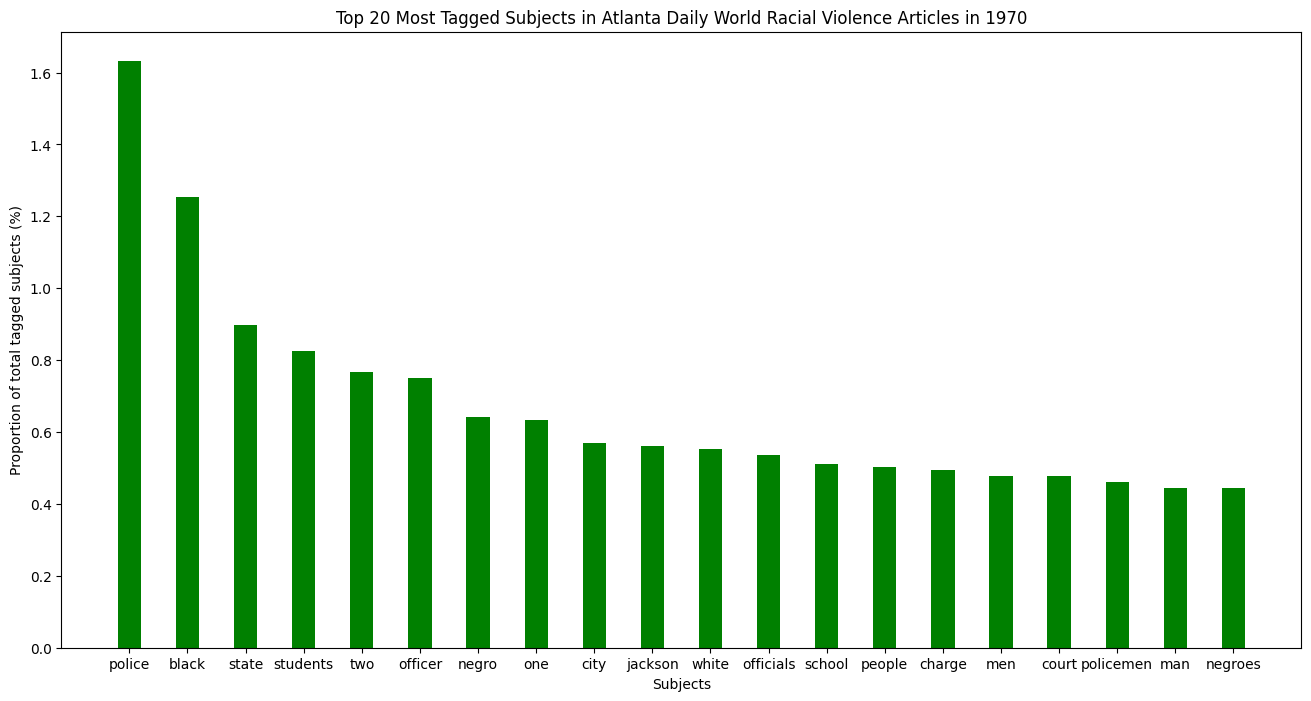

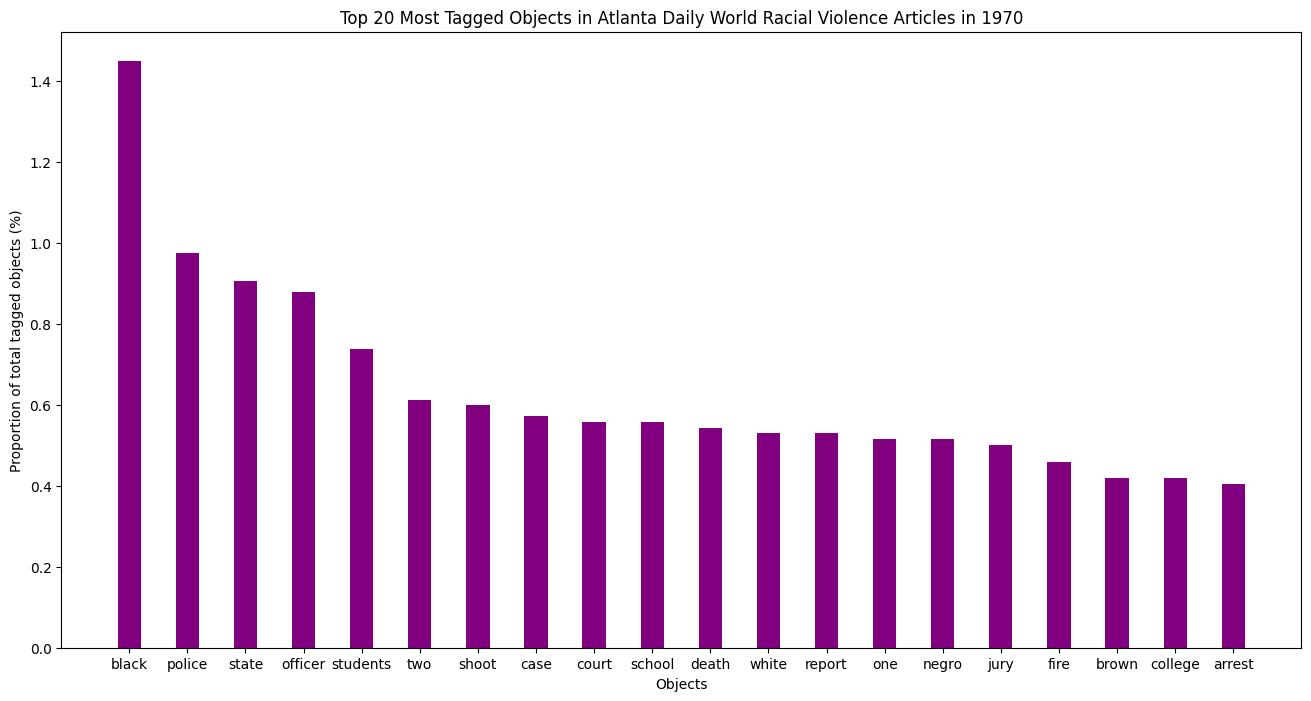

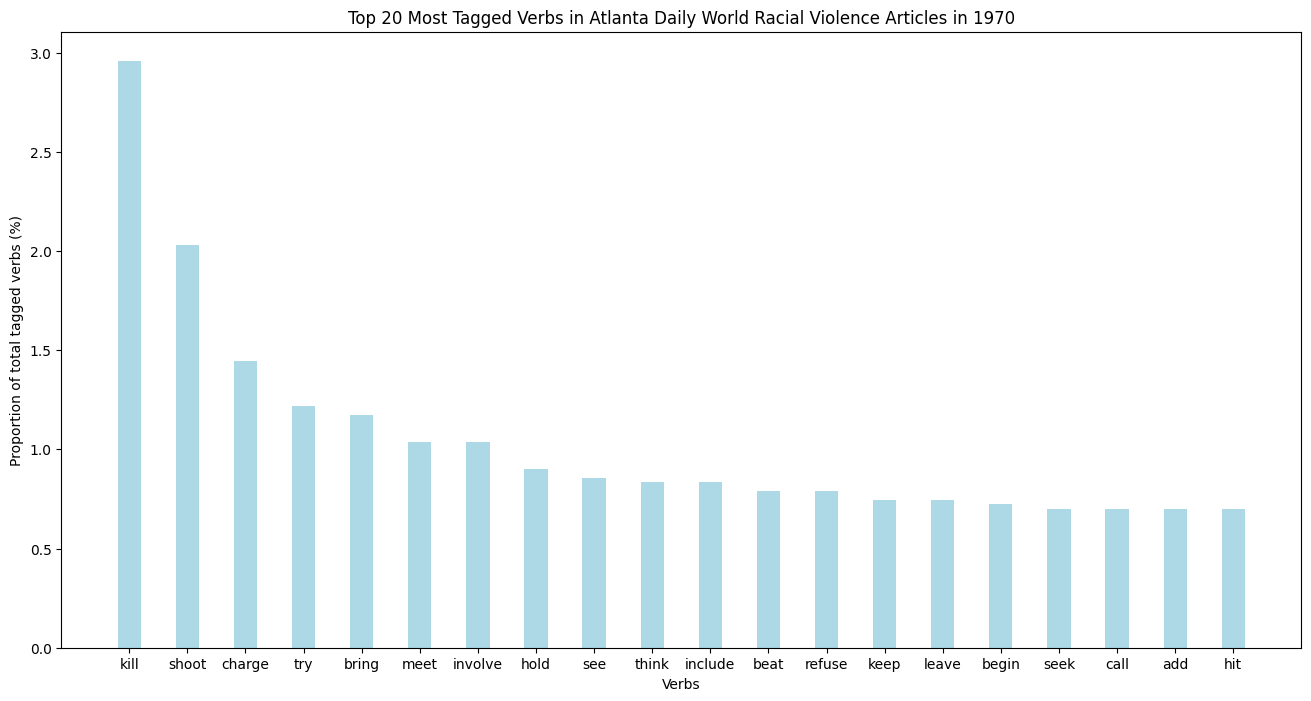

In [58]:
hist_top_sov(atl70[atl70['CF_Correct'] == 1].reset_index(), 'text', 'Atlanta Daily World Racial Violence Articles in 1970')